In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
data=pd.read_csv('/content/gdrive/MyDrive/train/train.csv')
data.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [4]:
ship= {'Cargo': 1, 
        'Military': 2, 
        'Carrier': 3, 
        'Cruise': 4, 
        'Tankers': 5}

# reverse the ship type dictionary

ship = dict([[v,k] for k,v in ship.items()])
data['Target']=data['category'].map(ship).astype('category')
data.head()

,image,category,Target
0,2823080.jpg,1,Cargo
1,2870024.jpg,1,Cargo
2,2662125.jpg,2,Military
3,2900420.jpg,3,Carrier
4,2804883.jpg,2,Military


(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.,
        2250.]), <a list of 10 Text major ticklabel objects>)

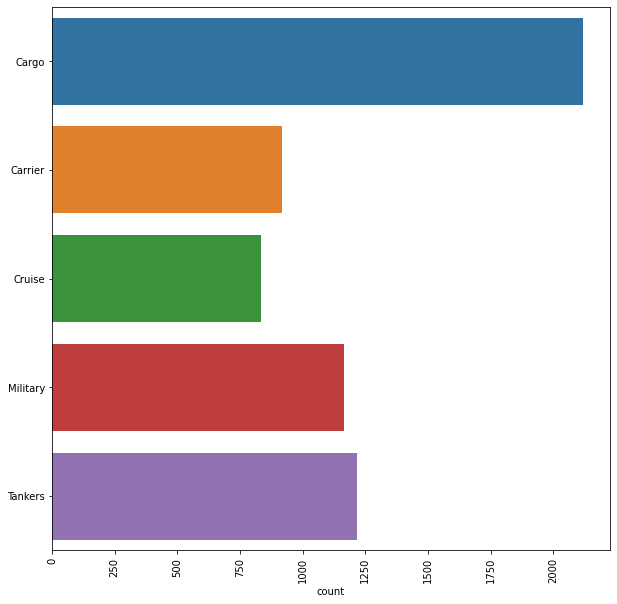

In [5]:
plt.figure(figsize=(10,10))
sns.countplot(y=data['Target'].values)
plt.xticks(rotation=90)

In [6]:
from sklearn.model_selection import train_test_split
train_df,test_df=train_test_split(data,test_size=0.25,random_state=42)

In [7]:
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

In [8]:
print('Train Data',train_df.shape)
print('Test Data',test_df.shape)

Train Data (4689, 3)
Test Data (1563, 3)


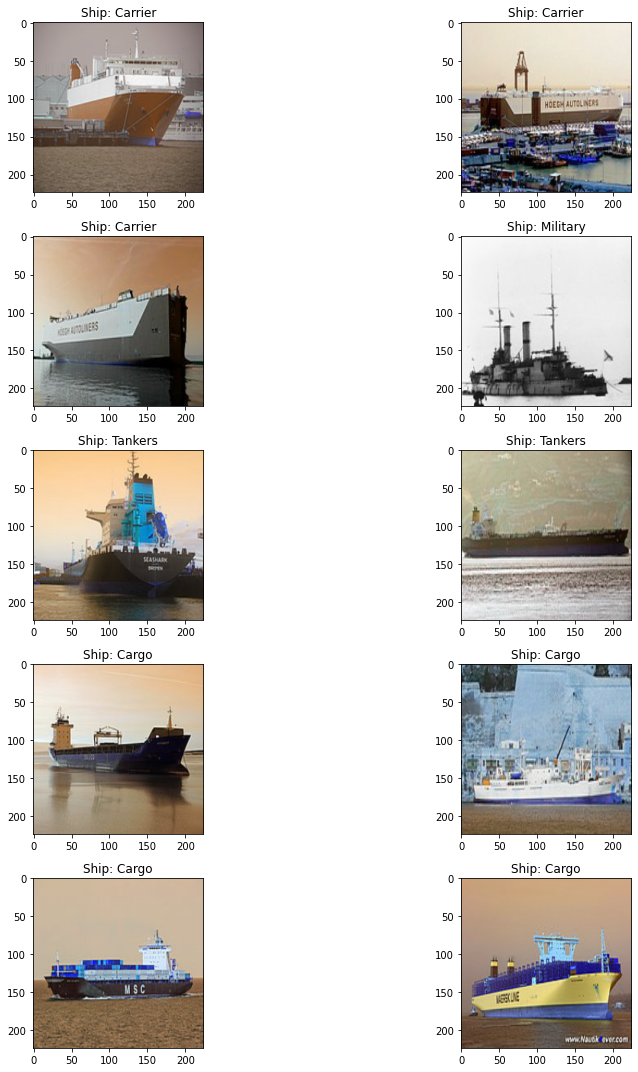

In [9]:
INPUT_PATH='/content/gdrive/MyDrive/train/images'
import random as rn
import cv2
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,data.shape[0])
        img = cv2.imread(INPUT_PATH+'/'+data.iloc[l][0],cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224,224))
        ax[i,j].imshow(img)
        ax[i,j].set_title('Ship: '+data.iloc[l][2])
plt.tight_layout()

## Apply Augmentation

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,featurewise_center=False,
                             featurewise_std_normalization=False,
                             rotation_range=10,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             zoom_range=(0.8, 1.2),
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,featurewise_center=False,
                             featurewise_std_normalization=False,
                             rotation_range=10,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             zoom_range=(0.8, 1.2),
)

In [11]:
train_images_aug = train_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=INPUT_PATH,
    x_col='image',
    y_col='Target',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=256,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images_aug = train_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=INPUT_PATH,
    x_col='image',
    y_col='Target',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=256,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images_aug = test_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=INPUT_PATH,
    x_col='image',
    y_col='Target',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=256,
    shuffle=False
)

Found 3752 validated image filenames belonging to 5 classes.
Found 937 validated image filenames belonging to 5 classes.
Found 1563 validated image filenames belonging to 5 classes.


**Metrics(F1_Score)**

In [12]:
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Pretrained VGG16

In [13]:
def create_model_inception(input_shape):
  base_model_inception = tf.keras.applications.inception_v3.InceptionV3(include_top=False, classes=5)
  inputs =Input(shape=(224,224,3), name='input_layer')
  #Scaling the values
  x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)
  #Pass inputs to our base_model
  x = base_model_inception(inputs,training=False)
  # GlobalAveragePooling2D
  Conv1 = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='Conv1')(x)
  #Batch Norm
  BN1=BatchNormalization()(Conv1)
  #MaxPool Layer
  Pool1 = MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid',data_format='channels_last',name='Pool1')(BN1)

  #Flatten
  flatten = Flatten(data_format='channels_last',name='Flatten')(Pool1)

  #Dropout
  DO1=Dropout(0.2)(flatten)
  #FC layer
  FC1 = Dense(units=50,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1')(DO1)
  DO2=Dropout(0.2)(FC1)
  #FC layer
  FC2 = Dense(units=30,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),name='FC2')(DO2)

  #output layer
  Out = Dense(units=5,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')(FC2)
  # Build model
  model= Model(inputs, Out)
  return model

In [14]:
model=create_model_inception(input_shape=(224,224,3))

87924736/87910968 [==============================] - 1s 0us/step


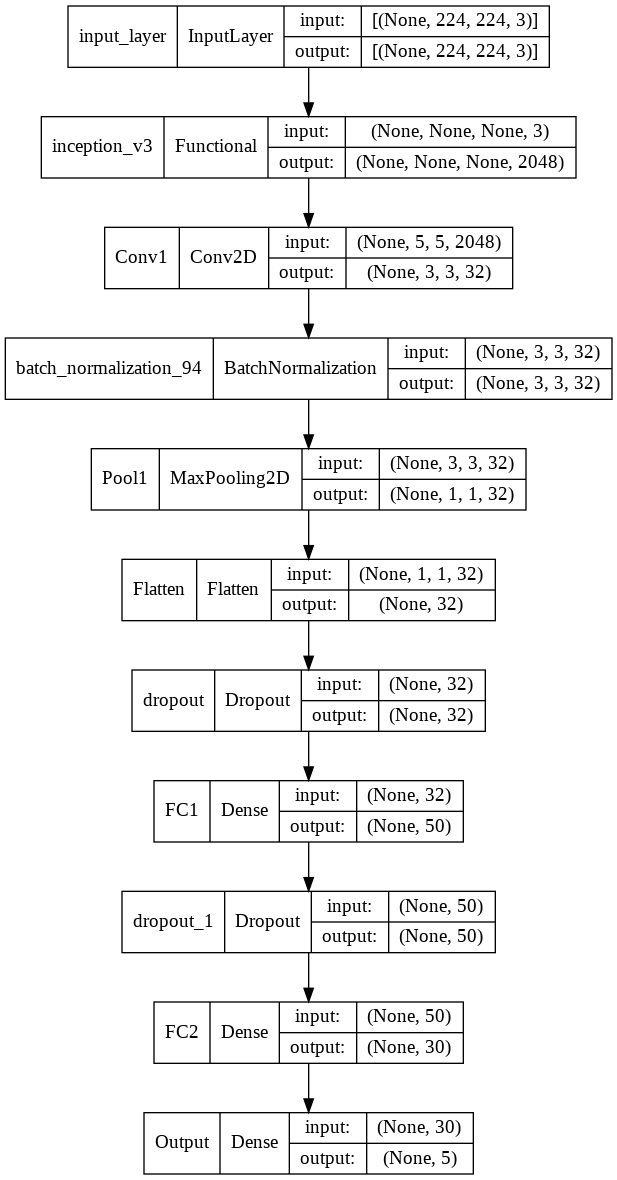

In [15]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,
rankdir='TB')

In [16]:
model.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy',f1_score])

In [17]:
from tensorflow.keras.callbacks import *
import os
%reload_ext tensorboard
filepath="/content/gdrive/MyDrive/Flower dataset/"
checkpoint = ModelCheckpoint(monitor='val_f1_score', mode='max', filepath=filepath, verbose=1, save_best_only=True, save_weights_only=False)
earlystop = EarlyStopping(monitor = 'val_f1_score',  mode="max",min_delta = 0, patience = 6,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_f1_score', factor = 0.25, patience = 3, verbose = 1,min_lr=0.000001)
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [reduce_lr,tensorboard,checkpoint,earlystop]

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
STEP_SIZE_TRAIN=train_images_aug.n//train_images_aug.batch_size
STEP_SIZE_VALID=val_images_aug.n//val_images_aug.batch_size
STEP_SIZE_TEST=test_images_aug.n//test_images_aug.batch_size
history=model.fit_generator(generator=train_images_aug,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_images_aug,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,callbacks=callbacks)

Epoch 1/25
14/14 [==============================] - ETA: 0s - loss: 1.6541 - accuracy: 0.2786 - f1_score: 0.0226  
Epoch 00001: val_f1_score improved from -inf to 0.32422, saving model to /content/gdrive/MyDrive/Flower dataset/
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Flower dataset/assets
14/14 [==============================] - 1472s 105s/step - loss: 1.6541 - accuracy: 0.2786 - f1_score: 0.0226 - val_loss: 43.7374 - val_accuracy: 0.3242 - val_f1_score: 0.3242 - lr: 0.0010
Epoch 2/25
14/14 [==============================] - ETA: 0s - loss: 1.4782 - accuracy: 0.3850 - f1_score: 0.1180
Epoch 00002: val_f1_score did not improve from 0.32422
14/14 [==============================] - 64s 5s/step - loss: 1.4782 - accuracy: 0.3850 - f1_score: 0.1180 - val_loss: 1231190.0000 - val_accuracy: 0.1810 - val_f1_score: 0.1810 - lr: 0.0010
Epoch 3/25
14/14 [==============================] - ETA: 0s - loss: 1.3843 - accuracy: 0.4302 - f1_score: 0.2506
Epoch 00003: val_f1_score did n

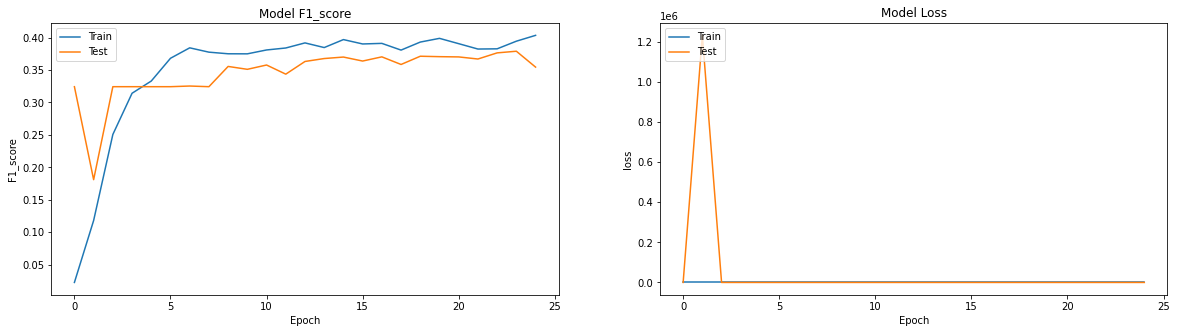

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1_score')
plt.ylabel('F1_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
pred = model.predict(test_images_aug)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_aug.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

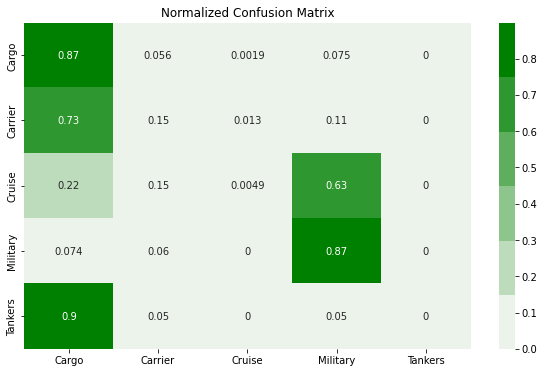

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_test = list(test_df.Target)
cf_matrix = confusion_matrix(y_test, pred,normalize='true')
plt.figure(figsize = (10,6))
cmap=sns.light_palette("green")
sns.heatmap(cf_matrix,cmap=cmap, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

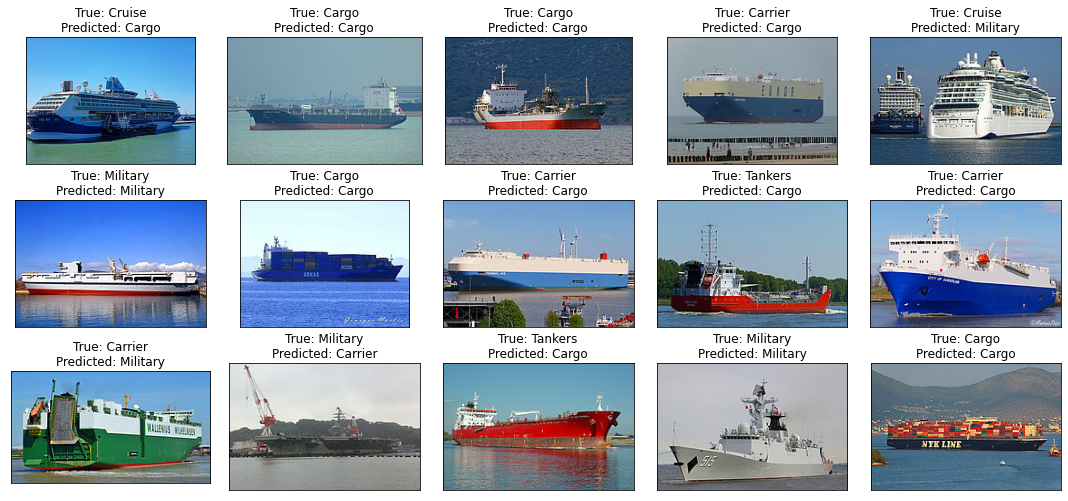

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(INPUT_PATH+'/'+test_df.image.iloc[i]))
    ax.set_title(f"True: {test_df.Target.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()